In [ ]:
RNN的问题

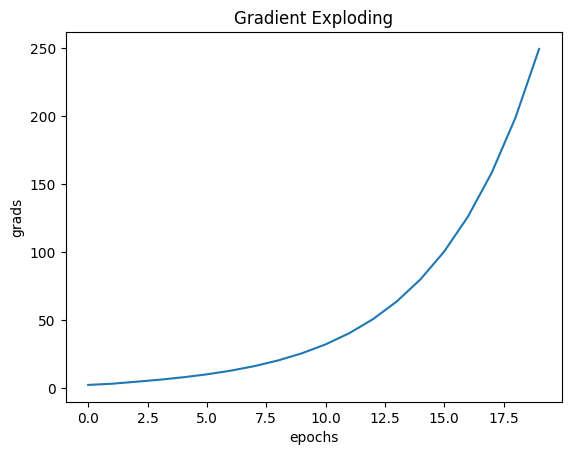

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N=2  #mini-batch的大小
H=3  #隐藏状态向量的维数
T=20 #时序数据的长度

dh=np.ones((N,H))
np.random.seed(3) #为了复现需固定随机种子
Wh=np.random.randn(H,H)

norm_list=[]
for t in range(T):
    dh=np.dot(dh,Wh.T)
    norm=np.sqrt(np.sum(dh**2))/N
    norm_list.append(norm)

x=range(0,T,1)
plt.title("Gradient Exploding")
plt.xlabel("epochs")
plt.ylabel("grads")
plt.plot(x,norm_list)
plt.show()

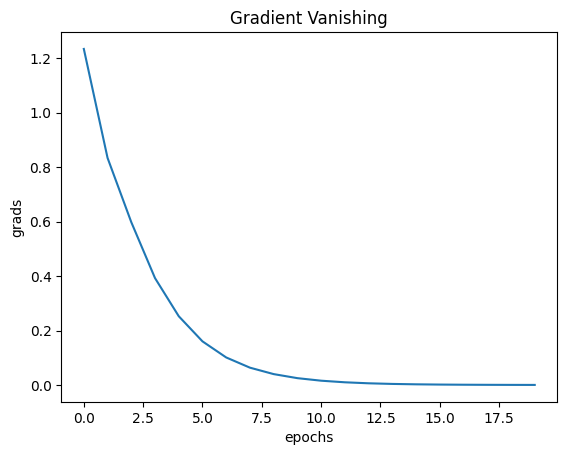

In [14]:
import numpy as np
import matplotlib.pyplot as plt

N=2  #mini-batch的大小
H=3  #隐藏状态向量的维数
T=20 #时序数据的长度

dh=np.ones((N,H))
np.random.seed(3) #为了复现需固定随机种子
Wh1=np.random.randn(H,H)*0.5
norm_list=[]
for t in range(T):
    dh=np.dot(dh,Wh1.T)
    norm=np.sqrt(np.sum(dh**2))/N
    norm_list.append(norm)

x=range(0,T,1)
plt.title("Gradient Vanishing")
plt.xlabel("epochs")
plt.ylabel("grads")
plt.plot(x,norm_list)
plt.show()

梯度裁剪

In [13]:
import numpy as np
dW1=np.random.rand(3,3)*10
dW2=np.random.rand(3,3)*10
grads=[dW1,dW2]
max_norm=5.0

def clip_grads(grads,max_norm):
    total_norm=0
    for grad in grads:
        total_norm+=np.sum(grad**2)
    total_norm=np.sqrt(total_norm)
    
    rate=max_norm/(total_norm+1e-6)
    if rate<1:
        for grad in grads:
            grad*=rate
print(clip_grads(grads,max_norm))

None


LSTM的实现

In [16]:
class LSTM:
    def __init__(self,Wx,Wh,b):
        self.params=[Wx,Wh,b]
        self.grads=[np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.cache=None  #保存在正向传播的中间结果
    
    def forward(self,h_prev,c_prev):  #接收当前时刻的输入x、上一时刻的隐藏状态h_prev、上一时刻的记忆单元c_prev
        Wx,Wh,b=self.params
        N,H=h_prev.shape
        
        A=np.dot(x,Wx)+np.dot(h_prev,Wh)+b
        
        #slice
        f=A[:,:H]
        g=A[:,H:2*H]
        i=A[:,2*H:3*H]
        o=A[:,3*H:]
        
        f=sigmoid(f)
        g=np.tanh(g)
        i=sigmoid(i)
        o=sigmoid(o)
        
        c_next=f*c_prev+g*i
        h_next=o*np.tanh(c_next)
        
        self.cache=(x,h_prev,c_prev,i,f,g,o,c_next)
        return h_next,c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

Time LSTM 层的实现

In [17]:
import numpy as np

In [18]:
class TimeLSTM:
    def __init__(self,Wx,Wh,b,stateful=False):
        self.params=[Wx,Wh,b]
        self.grads=[np.zero_like(Wx),np.zero_like(Wh),np.zero_like(b)]
        self.layers=None
        
        self.h,self.c=None,None
        self.dh=None
        self.stateful=stateful
        
    def forward(self,xs):
        Wx,Wh,b=self.params
        N,T,D=xs.shape
        H=Wh.shape[0]
        
        self.layers=[]
        hs=np.empty((N,T,H),dtype='f')
        
        if not self.stateful or self.h is None:
            self.h=np.zeros((N,H),dtype='f')
        if not self.stateful or self.c is None:
            self.c=np.zeros((N,H),dtype='f')
            
        for t in range(T):
            layer=LSTM(*self.params)
            self.h,self.c=layer.forward(xs[:,t,:],self.h,self.c)
            hs[:,t,:]=self.h
            
            self.layers.append(layer)
            
        return hs
    
    def backward(self,dhs):
        Wx,Wh,b=self.params
        N,T,H=dhs.shape
        D=Wx.shape[0]
        
        dxs=np.empty((N,T,D),dtype='f')
        dh,dc=0,0
        
        grads=[0,0,0]
        for t in reversed(range(T)):
            layer=self.layers[t]
            dx,dh,dc=layer.backward(dhs[:,t,:]+dh,dc)
            dxs[:,t,:]=dx
            for i,grad in enumerate(layer.grads):
                grads[i]+=grad
                
        for i,grad in enumerate(grads):
            self.grads[i][...]=grad
            self.dh=dh
            return dxs
        
        def set_state(self,h,c=None):
            self.h,self.c=h,c
            
        def reset_state(self):
            self.h,self.c=None,None
        

使用LSTM层实现的RnnLM类

In [19]:
import sys
import numpy as np
sys.path.append('..')
from common.time_layers import *
import pickle

class RnnLM:
    def __init__(self,vocab_size=10000,wordvec_size=100,hidden_size=100):
        V,D,H=vocab_size,wordvec_size,hidden_size
        rn=np.random.randn
        
        #初始化权重
        embed_W=(rn(V,D)/100).astype('f')
        lstm_Wx=(rn(D,4*H)/np.sqrt(D)).astype('f')
        lstm_Wh=(rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b=np.zeros(4*H).astype('f')
        affine_W=(rn(H,V)/np.sqrt(H)).astype('f')
        affine_b=np.zeros(V).astype('f')
        
        #生成层
        self.layers=[
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx,lstm_Wh,lstm_b,stateful=True),
            TimeAffine(affine_W,affine_b)
        ]
        self.loss_layer=TimeSoftmaxWithLoss()
        self.lstm_layer=self.layers[1]
        
        #将所有的权重和梯度整理到列表中
        self.params,self.grads=[],[]
        for layer in self.layers:
            self.params+=layer.params
            self.grads+=layer.grads
            
    def predict(self,xs):
        for layer in self.layers:
            xs=layer.forward(xs)
        return xs
    
    def forward(self,xs,ts):
        score=self.predict(xs)
        loss=self.loss_layer.forward(score,ts)
        return loss
    
    def backward(self,dout=1):
        dout=self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout=layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
        
    def save_params(self,file_name='RnnLM.pkl'):
        with open(file_name,'wb') as f:
            pickle.dump(self.params,f)
            
    def load_params(self,file_name='RnnLM.pkl'):
        with open(file_name,'rb') as f:
            self.params=pickle.load(f)

使用PTB数据集的训练数据进行学习

In [20]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
import ssl

#设定超参数
batch_size=20
wordvec_size=100
hidden_size=100
time_size=35 #RNN的展开大小

lr=20.0
max_epoch=4
max_grad=0.25  #为了进行梯度裁剪

#读入训练数据
ssl._create_default_https_context = ssl._create_unverified_context
corpus,word_to_id,id_to_word=ptb.load_data('train')
corpus_test, _,_=ptb.load_data('test')
vocab_size=len(word_to_id)
xs=corpus[:-1]
ts=corpus[1:]

In [6]:
#生成模型
model=RnnLM(vocab_size,wordvec_size,hidden_size)
optimizer=SGD(lr)
trainer=RnnlmTrainer(model,optimizer)

#应用梯度裁剪进行学习
trainer.fit(xs,ts,max_epoch,batch_size,time_size,max_grad,eval_interval=20)  #求模型梯度，并更新模型的参数；eval_interval=20表示没20次迭代对困惑度进行一次评价
trainer.plot(ylim=(0,500))

#基于测试数据进行评价
model.reset_state()  #需重置模型的状态（LSTM的隐藏状态和记忆单元）
ppl_test=eval_perplexity(model,corpus_test)
print('Test Perplexity: ',ppl_test)

#保存参数
model.save_params()

| epoch 1 |  iter 1 / 1327 | time 20[s] | perplexity 10002.91


KeyboardInterrupt: 

进一步改进RNNLM

In [21]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel

class BetterRnnLM(BaseModel):
    def __init__(self,vocab_size=10000,wordvec_size=650,hidden_size=650,dropout_ratio=0.5):
        V,D,H=vocab_size,wordvec_size,hidden_size
        rn=np.random.randn
        
        embed_W=(rn(V,D)/100).astype('f')
        lstm_Wx1=(rn(D,4*H)/np.sqrt(D)).astype('f')
        lstm_Wh1=(rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b1=np.zeros(4*H).astype('f')
        lstm_Wx2=(rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_Wh2=(rn(H,4*H)/np.sqrt(H)).astype('f')        
        lstm_b2=np.zeros(4*H).astype('f')
        affine_b=np.zeros(V).astype('f')
        
        #3点改进
        self.layers=[
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1,lstm_Wh1,lstm_b1,stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2,lstm_Wh2,lstm_b2,stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T,affine_b)   #权重共享
        ]
        self.loss_layer=TimeSoftmaxWithLoss()
        self.lstm_layers=[self.layers[2],self.layers[4]]
        self.drop_layers=[self.layers[1],self.layers[3],self.layers[5]]
        self.params,self.grads=[],[]
        for layer in self.layers:
            self.params+=layer.params
            self.grads+=layer.grads
            
    def predict(self,xs,train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg=train_flg
        for layer in self.layers:
            xs=layer.forward(xs)
        return xs
    
    
    def forward(self,xs,ts,train_flg=True):
        score=self.predict(xs,train_flg)
        loss=self.loss_layer.forward(score,ts)
        return loss
    
    def backward(self,dout=1):
        dout=self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout=layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

使用改进过的BetterRNNLM类学习

In [ ]:
import sys
import ssl
sys.path.append('..')
from common import config
config.GPU=True
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

#设定超参数
batch_size=20
wordvec_size=650
hidden_size=650
time_size=35
lr=20.0
max_epoch=40
max_grad=0.25
dropout=0.5

#读入训练数据
ssl._create_default_https_context = ssl._create_unverified_context
corpus,word_to_id,id_to_word=ptb.load_data('train')
corpus_val, _,_ =ptb.load_data('val')
corpus_test, _,_ =ptb.load_data('test')

vocab_size=len(word_to_id)
xs=corpus[:-1]
ts=corpus[1:]

model =BetterRnnLM(vocab_size,wordvec_size,hidden_size,dropout)
optimizer=SGD(lr)
trainer=RnnlmTrainer(model,optimizer)
best_ppl=float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs,ts,max_epoch=1,batch_size=batch_size,time_size=time_size,max_grad=max_grad)
    model.reset_state
    ppl=eval_perplexity(model,corpus_val)
    print('Valid Perplexity: ',ppl)
    
    if best_ppl>ppl:
        best_ppl=ppl
        model.save_params()
    else:
        lr/=4.0
        optimizer.lr=lr
    model.reset_state()
    print('-'*50)

Done
| epoch 1 |  iter 1 / 1327 | time 317[s] | perplexity 10000.33
